<a href="https://colab.research.google.com/github/Mountain-C/Class-Projects/blob/master/Class-Projects/Codes/Numerical_Analysis/Generic_Solver_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(array([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 0, 0, 6],
        [0, 1, 2, 0, 0, 0, 6],
        [0, 1, 2, 3, 4, 5, 6]]), array([[0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 0, 0, 3],
        [4, 4, 4, 0, 0, 0, 4],
        [5, 5, 5, 5, 5, 5, 5]]), array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  1.    ,  1.    ,  1.    ,  1.    ,  0.    ],
        [ 0.    , -1.75  , -1.75  ,  0.    ,  0.    ,  0.    ],
        [ 0.    , -7.1875,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]]))

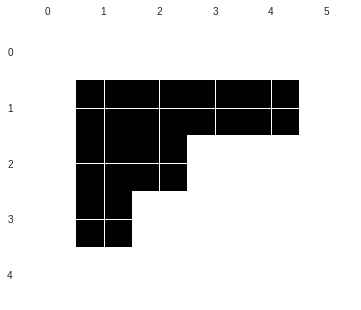

In [ ]:
import numpy as np
import scipy.signal as signal
import scipy
import matplotlib.pyplot as plt  

def rhs(x, y):
    # Element-wise multiplication
    return np.multiply(x, (x - y)**3)

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

domain = np.vstack([[1,1,1,1],[1,1,0,0], [1,0,0,0]])
        
        
def matrix_generator(inputStepSize, rhsEquation, domainMatrix, *args,**kwargs):

  # Solve poisson equation with domain given by unit squares in
  # matrix. The differential equation is then represented by a
  # matrix system of equations to solve.
    
    # Stride length
    steps = round(1 / inputStepSize)
    # Expand the domain using the kronecker product
    refinedDomain = np.kron(domainMatrix, np.ones(steps))    
    leftSide = np.kron(refinedDomain[:, 0], np.ones((1, steps - 1)))
    leftBoundary = np.zeros((refinedDomain.shape[0], 1))
    rightBoundary = np.copy(leftBoundary)
    debugging = [(np.shape(arr)) for arr in (leftBoundary, leftSide, refinedDomain, rightBoundary)]
    refinedDomain = np.hstack((leftBoundary, refinedDomain, rightBoundary))


    # Fix y axis missing expanded values and boundaries
    belowboundary = np.kron(refinedDomain[0, ], np.ones( (steps - 1, 1)))
    topBoundary = np.zeros( (1, belowboundary.shape[1]))
    bottomBoundary = np.copy(topBoundary)
    refinedDomain = np.concatenate((bottomBoundary, belowboundary,
                                    refinedDomain, topBoundary), axis = 0)    
    
    # plot the pattern of the domain to ensure it is correct - 
#      used for debugging
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.spy(refinedDomain);
    
    x_interior, y_interior = np.where(refinedDomain != 0)
    
    # Scale x and y points based on step size
    x_interior = inputStepSize * x_interior
    y_interior = inputStepSize * y_interior
    
    operatorMatrix = 4 * scipy.sparse.eye(x_interior.size).toarray()

    #Iterate through each neighborhood and assign -1 where necessary
    for i in np.arange(0, x_interior.size).reshape(-1):
      current_x = np.array(x_interior[i])
      current_y = np.array(y_interior[i])

      currentPoint = np.hstack((current_x, current_y))
      above = np.hstack((currentPoint[0], currentPoint[1] + inputStepSize))
      below = np.hstack((currentPoint[0], currentPoint[1] - inputStepSize))
      left = np.hstack((currentPoint[0] - inputStepSize, currentPoint[1]))
      right = np.hstack((currentPoint[0] + inputStepSize, currentPoint[1]))

      neighbors = np.vstack((above, below, left, right))

      for j in np.arange(1, neighbors.size / 2).reshape(-1):
        x_indices = np.where(x_interior == np.vstack((neighbors[int(j), 0],
                                                  neighbors[int(j), 1]))[0][0])

        index = np.where(
          y_interior[x_indices] == np.vstack((neighbors[int(j), 0],
                                                  neighbors[int(j), 1]))[1][0])
        operatorMatrix[i, index] = -1

    # Create right hand side vector
    rhsVector = np.dot(inputStepSize ** 2, rhsEquation(x_interior, y_interior))

    # Solve the system
    solutionMatrix = np.linalg.solve(operatorMatrix, rhsVector)

    # Coordinates plotted for visualization
    X,Y = np.meshgrid(np.arange(0, np.size(refinedDomain, axis = 1) + 1, 
                                inputStepSize), 
                      np.arange(0, np.size(refinedDomain, axis = 0) + 1, inputStepSize))

    Z = np.copy(refinedDomain)
    (i, j) = (Z != 0).nonzero()
    for solution in np.arange(0, np.size(solutionMatrix)).reshape(-1):
      Z[i, j] = solutionMatrix[i]

    # Remove x and y coordinates that are not within the domain or boundary
    arr_temp = np.vstack([[1,1,1],[1,0,1],[1,1,1]])
    convolve2d_temp = np.logical_not(signal.convolve2d(Z, arr_temp, mode='same'))
    zeroIndices = np.where(convolve2d_temp)
    X[zeroIndices] = 0
    Y[zeroIndices] = 0
    
    return X, Y, Z

matrix_generator(1, rhs, domain)
# print(X.shape, Y.shape, Z.shape)

In [ ]:
from IPython.core.display import display, HTML
import json
import numpy as np

def plot3D(X, Y, Z, height=600, xlabel = "X", ylabel = "Y", zlabel = "Z", initialCamera = None):

    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }

    if initialCamera:
        options["cameraPosition"] = initialCamera
        
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))


In [ ]:
print(X.shape, Y.shape, Z.shape)

(28, 112) (28, 112) (6, 27)
